In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_csv('mushroom/secondary_data.csv', sep=';')
print(df.shape)
df.head()

(61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [46]:
df.groupby(['class'])['class'].count() / df.shape[0]

class
e    0.445087
p    0.554913
Name: class, dtype: float64

In [12]:
print("The data types of the columns are:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.dtypes)

The data types of the columns are:
class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object


The features are:\
n: nominal, m: metrical
- **cap-diameter (m)**: float number in cm
- **cap-shape (n)**: bell=b, conical=c, convex=x, flat=f, sunken=s, spherical=p, others=o
- **cap-surface (n)**: fibrous=i, grooves=g, scaly=y, smooth=s, shiny=h, leathery=l, silky=k, sticky=t, wrinkled=w, fleshy=e
- **cap-color (n)**: brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k
- **does-bruise-bleed (n)**: bruises-or-bleeding=t,no=f
- **gill-attachment (n)**: adnate=a, adnexed=x, decurrent=d, free=e, sinuate=s, pores=p, none=f, unknown=?
- **gill-spacing (n)**: close=c, distant=d, none=f
- **gill-color (n)**: see cap-color + none=f
- **stem-height (m)**: float number in cm

In [13]:
# change column type from object to category
for col in ['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color','veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color','habitat', 'season']:
       df[col] = df[col].astype('category')

In [14]:
# Check the missing values of data
# columns that have missing value
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values in features:
cap-surface          0.231214
gill-attachment      0.161850
gill-spacing         0.410405
stem-root            0.843931
stem-surface         0.624277
veil-type            0.947977
veil-color           0.878613
ring-type            0.040462
spore-print-color    0.895954
dtype: float64


In [15]:
# split the features and target variable
y = df['class']
X = df.drop(columns='class')
print(X.shape, y.shape)

(61069, 20) (61069,)


# EDA

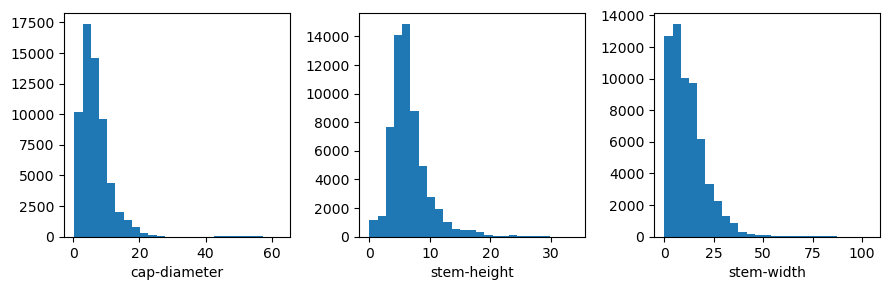

In [49]:
# The histogram of all the features
plt.figure(figsize=(9,3))
i=0
for col in ['cap-diameter', 'stem-height', 'stem-width']:
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=25)
    plt.xlabel("{}".format(col), fontsize=10)
    i += 1
plt.tight_layout()
plt.show()

In [17]:
count_matrix = df.groupby(['cap-color', 'class']).size().unstack()
print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0).sort_values(['e'], ascending=False)
print(count_matrix_norm)

class          e      p
cap-color              
b            974    256
e            880   3155
g           2297   2123
k            501    778
l            452    376
n          12407  11811
o           1071   2585
p            449   1254
r            198   1584
u            611   1098
w           3750   3916
y           3591   4952
class             e         p
cap-color                    
b          0.791870  0.208130
l          0.545894  0.454106
g          0.519683  0.480317
n          0.512305  0.487695
w          0.489173  0.510827
y          0.420344  0.579656
k          0.391712  0.608288
u          0.357519  0.642481
o          0.292943  0.707057
p          0.263652  0.736348
e          0.218092  0.781908
r          0.111111  0.888889


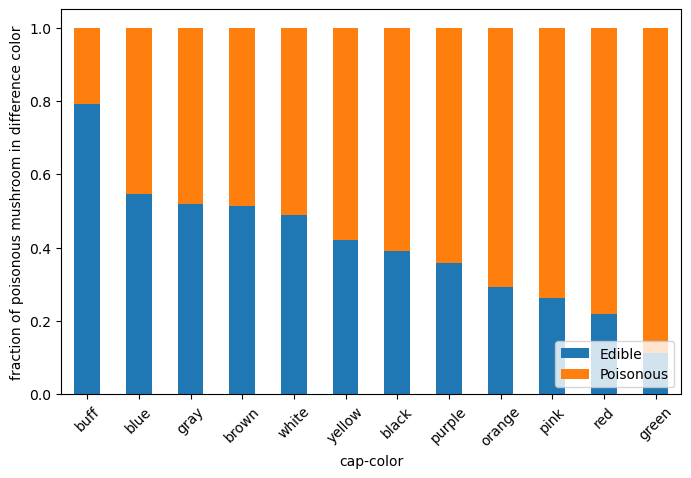

In [18]:
count_matrix_norm.plot(kind='bar', stacked=True, figsize=(8,5))
plt.ylabel('fraction of poisonous mushroom in difference color')
plt.legend(loc=4, labels=['Edible', 'Poisonous'])
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], 
           ['buff','blue','gray','brown','white','yellow','black','purple','orange','pink','red','green'], rotation=45)
plt.show()

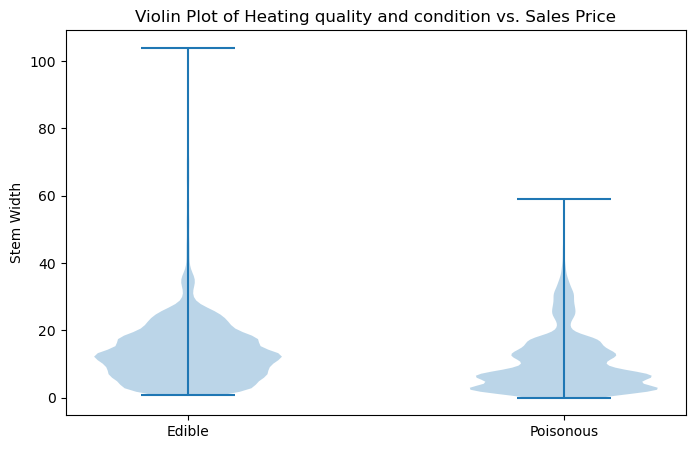

In [19]:
# your code here 
dataset = [df[df['class']=='e']['stem-width'].values,
           df[df['class']=='p']['stem-width'].values]

plt.figure(figsize=(8,5))

plt.violinplot(dataset = dataset)
plt.xticks([1,2],['Edible','Poisonous'])
plt.ylabel('Stem Width')
plt.title('Violin Plot of Heating quality and condition vs. Sales Price')
plt.show()

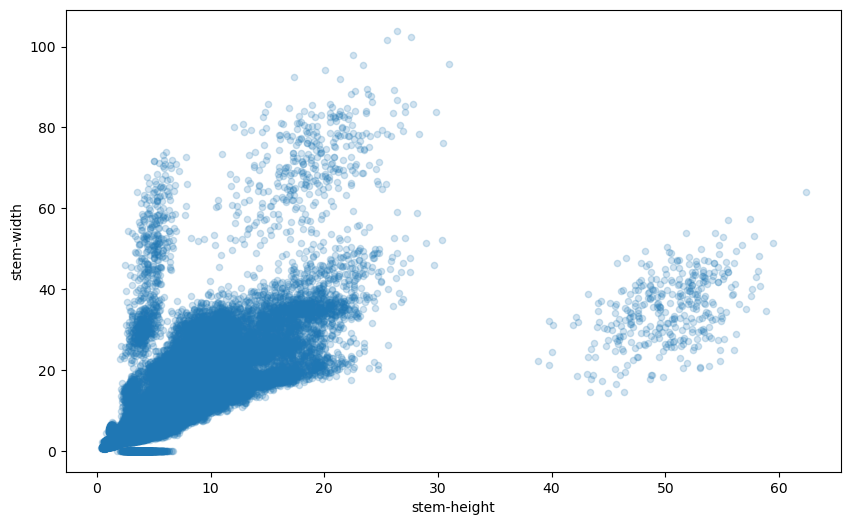

In [20]:
df.plot.scatter('cap-diameter','stem-width', figsize=(10,6), alpha=0.2,s=20)
plt.xlabel('stem-height')
plt.ylabel('stem-width')
plt.show()

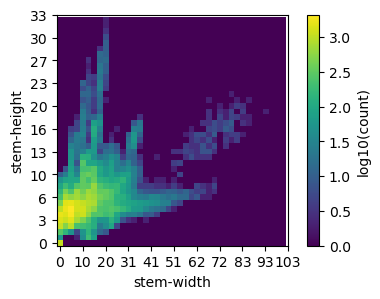

In [21]:
nbins = 40

heatmap, xedges, yedges = np.histogram2d(df['stem-width'], df['stem-height'], bins=nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

heatmap[heatmap == 0] = 0.1 # we will use log and log(0) is undefined
plt.figure(figsize=(5,3))

plt.imshow(np.log10(heatmap).T, origin='lower',vmin=0) # use log count
plt.xlabel('stem-width')
plt.ylabel('stem-height')
plt.xticks(np.arange(nbins+1)[::4],xedges[::4].astype(int))
plt.yticks(np.arange(nbins+1)[::4],yedges[::4].astype(int))
plt.colorbar(label='log10(count)')
plt.show()

# splitting

In [22]:
# load the function
# split function
def basic_split(X, y, train_size, val_size, test_size, random_state):
    # test the inputs
    if (train_size+val_size+test_size != 1):
        print("The split size does not add up to 1")
        raise ValueError
    if not isinstance(random_state, int):
        print("The random state entered in not an integer")
        raise ValueError
    if X.shape[0] != y.shape[0]:
        print("The number of rows in X is not the same as the length of y")
        raise ValueError
    if len(X.shape) != 2:
        print("Input X is not a 2-D pandas dataframe")
        raise ValueError
    if len(y.shape) != 1:
        print("Input y is not a 1-D pandas series")
        raise ValueError

    # split the dataset
    X_train, X_other, y_train, y_other = train_test_split(X, y,
                                                          train_size = train_size, 
                                                          random_state = random_state)
    # calculate the correct size when splitting _other to _val and _test
    val_size_new = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_other, y_other,
                                                    train_size = val_size_new, 
                                                    random_state = random_state)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [23]:
# split the dataset
X_train, y_train, X_val, y_val, X_test, y_test = basic_split(X, y, train_size = 0.7, val_size = 0.15, test_size = 0.15, random_state=42)
print('The shape of each train, val, and test set are the following:')
print('X_train: {a}, X_val: {b}, X_test: {c}'.format(a=X_train.shape, b=X_val.shape, c=X_test.shape))
print('y_train: {a}, y_val: {b}, y_test: {c}'.format(a=y_train.shape, b=y_val.shape, c=y_test.shape))

The shape of each train, val, and test set are the following:
X_train: (42748, 20), X_val: (9160, 20), X_test: (9161, 20)
y_train: (42748,), y_val: (9160,), y_test: (9161,)


# preprocessing

In [41]:
onehot_features = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color','stem-root', 
                'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
std_features = ['cap-diameter','stem-height','stem-width']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_features),
        ('std', StandardScaler(), std_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here
clf.set_output(transform='pandas')

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print('Shape of X_train before transformation:', X_train.shape)
print('Shape of X_train after transformation:', X_train_prep.shape)
X_train_prep.head()


Shape of X_train before transformation: (42748, 20)
Shape of X_train after transformation: (42748, 128)


,onehot__cap-shape_b,onehot__cap-shape_c,onehot__cap-shape_f,onehot__cap-shape_o,onehot__cap-shape_p,onehot__cap-shape_s,onehot__cap-shape_x,onehot__cap-surface_d,onehot__cap-surface_e,onehot__cap-surface_g,...,onehot__habitat_p,onehot__habitat_u,onehot__habitat_w,onehot__season_a,onehot__season_s,onehot__season_u,onehot__season_w,std__cap-diameter,std__stem-height,std__stem-width
60500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.267047,-0.037636,1.053230
932,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.156232,1.242168,0.203859
28092,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.185551,-0.589533,0.075858
37517,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.867945,0.108542,-0.973949
26695,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.378147,-0.106250,-0.192051


In [43]:
# Check the missing values of data
# columns that have missing value
perc_missing_per_ftr = X_train_prep.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values in features:
Series([], dtype: float64)


Among 20 features, there are 9 features that comtains missing value. 